## 1. Import Necessary Libraries
We begin by importing essential Python libraries required for data manipulation, machine learning, and model evaluation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE  # SMOTE for resampling
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV


## 2. Load the Dataset
The dataset is loaded from a CSV file. The dataset contains information about customers, including features such as demographics, service usage, and whether the customer churned.

In [5]:
df = pd.read_csv('customer.csv')


## 3. Data Exploration
We begin exploring the dataset to understand its shape, types of columns, and any potential issues like missing values.

In [8]:
# Data Exploration
print("Dataset Shape:", df.shape)
print("Dataset Info:")
df.info()

Dataset Shape: (7043, 21)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Pa

The df.shape gives the number of rows and columns in the dataset.
df.info() displays details like column types and non-null counts.


## 4. Check for Missing Values
Missing values are identified in the dataset using isnull().sum(). If there are any missing values, appropriate handling is done in the next step.

In [15]:
# Checking for missing values
print("Missing values:")
print(df.isnull().sum())


Missing values:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


## 5. Handle Missing Values
We handle the missing values in the TotalCharges column. We convert this column to numeric and fill missing values with the median.

In [17]:
# Handle missing values (if any)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())  # Fix chained assignment warning


## 6. Convert Categorical Columns to Numeric
We transform categorical columns (binary features) to numerical values (1 for 'Yes', 0 for 'No') using a lambda function.

In [20]:
# Convert categorical columns to numerical ones
binary_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in binary_columns:
    df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)


## 7. One-Hot Encoding for Non-Binary Categorical Variables
For non-binary categorical variables like gender, InternetService, Contract, and PaymentMethod, we use one-hot encoding to convert them into numerical values.

In [23]:
# One-hot encoding for non-binary categorical variables
df = pd.get_dummies(df, columns=['gender', 'InternetService', 'Contract', 'PaymentMethod'], drop_first=True)


## 8. Split Data into Features and Target
We separate the dataset into features (X) and target (y). The target variable Churn represents customer churn, while the rest are features.

In [26]:
# Split data into features (X) and target (y)
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

## 9. Train-Test Split
We split the data into training and testing sets. The test set is set to 20% of the dataset, and we ensure that the distribution of churned vs non-churned customers is the same in both sets (stratify=y).

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


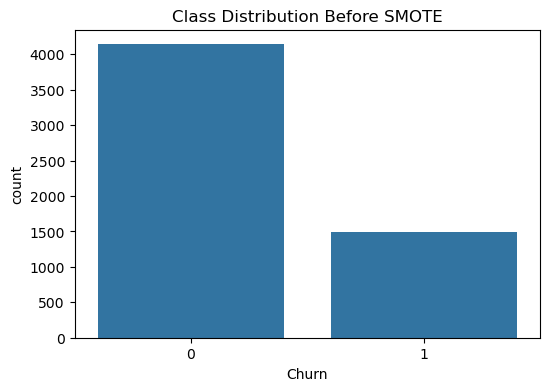

In [78]:
# Visualize the class distribution before SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution Before SMOTE')
plt.show()



## 10. Handle Class Imbalance: Apply SMOTE
We apply the SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class (churned customers) in the training set to balance the class distribution.

In [34]:
# Handle class imbalance: Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


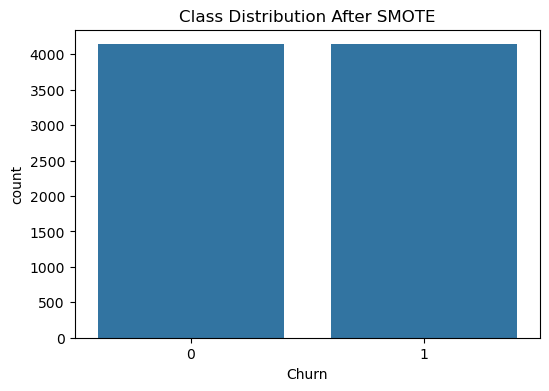

In [80]:
# Visualize the class distribution after applying SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution After SMOTE')
plt.show()

## 11. Define Models
We define a dictionary of machine learning models that we will be using for classification. These include Random Forest, Logistic Regression, XGBoost, and LightGBM.

In [37]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled == 0), random_state=42),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42)
}


## 12. Hyperparameter Tuning with GridSearchCV
We perform hyperparameter tuning using GridSearchCV to find the best hyperparameters for each model. We define grids of parameters to search over for each model.

In [40]:
# Hyperparameter tuning with GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_logreg = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}


## 13. Fit GridSearchCV for Each Model
We perform the grid search for each model, looking for the best hyperparameters based on cross-validation.

In [43]:
# Grid search for each model
grid_search_rf = GridSearchCV(estimator=models['Random Forest'], param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_logreg = GridSearchCV(estimator=models['Logistic Regression'], param_grid=param_grid_logreg, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb = GridSearchCV(estimator=models['XGBoost'], param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_lgb = GridSearchCV(estimator=models['LightGBM'], param_grid=param_grid_lgb, cv=3, n_jobs=-1, verbose=2)


## 14. Fit the Best Models
After finding the best parameters, we select the best estimator from the grid search and fit the models.

In [46]:
# Fit the grid search for each model
grid_search_rf.fit(X_train_resampled, y_train_resampled)
grid_search_logreg.fit(X_train_resampled, y_train_resampled)
grid_search_xgb.fit(X_train_resampled, y_train_resampled)
grid_search_lgb.fit(X_train_resampled, y_train_resampled)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [100, 200],
                         'num_leaves': [31, 50, 100]},
             verbose=2)

## 15. Print Best Parameters
Once the models are trained, we print the best hyperparameters found for each model.

In [52]:
# Print the best parameters for each model
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Parameters for Logistic Regression:", grid_search_logreg.best_params_)
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best Parameters for LightGBM:", grid_search_lgb.best_params_)


Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Parameters for Logistic Regression: {'C': 0.1, 'max_iter': 200}
Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
Best Parameters for LightGBM: {'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 100}


## 16. Train the Best Models
Now that we have the best models, we fit them on the resampled training data.

In [54]:
# Use the best models
best_rf = grid_search_rf.best_estimator_
best_logreg = grid_search_logreg.best_estimator_
best_xgb = grid_search_xgb.best_estimator_
best_lgb = grid_search_lgb.best_estimator_

# Train the models
best_rf.fit(X_train_resampled, y_train_resampled)
best_logreg.fit(X_train_resampled, y_train_resampled)
best_xgb.fit(X_train_resampled, y_train_resampled)
best_lgb.fit(X_train_resampled, y_train_resampled)


C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.2, num_leaves=100,
               random_state=42)

## 17. Calibrate the Models
We calibrate the models using Platt Scaling to improve the probability predictions. This is particularly useful when the output needs to be a probability score.

In [57]:
# Calibrate the models (Platt Scaling for better probability prediction)
calibrated_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv=3)
calibrated_logreg = CalibratedClassifierCV(best_logreg, method='sigmoid', cv=3)
calibrated_xgb = CalibratedClassifierCV(best_xgb, method='sigmoid', cv=3)
calibrated_lgb = CalibratedClassifierCV(best_lgb, method='sigmoid', cv=3)

calibrated_rf.fit(X_train_resampled, y_train_resampled)
calibrated_logreg.fit(X_train_resampled, y_train_resampled)
calibrated_xgb.fit(X_train_resampled, y_train_resampled)
calibrated_lgb.fit(X_train_resampled, y_train_resampled)


C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2759, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 5518, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2760, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [I

CalibratedClassifierCV(cv=3,
                       estimator=LGBMClassifier(class_weight='balanced',
                                                learning_rate=0.2,
                                                num_leaves=100,
                                                random_state=42))

## 18. Evaluate the Models
We predict and evaluate the models using accuracy, classification report, and confusion matrix.

In [60]:
# Predict and evaluate the models
models_calibrated = {
    'Random Forest': calibrated_rf,
    'Logistic Regression': calibrated_logreg,
    'XGBoost': calibrated_xgb,
    'LightGBM': calibrated_lgb
}

for model_name, model in models_calibrated.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Evaluating Random Forest...
Accuracy Score: 0.7735982966643009
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.56      0.64      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409

Confusion Matrix:
 [[849 186]
 [133 241]]

Evaluating Logistic Regression...
Accuracy Score: 0.7572746628814763
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1035
           1       0.54      0.64      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.76      1409

Confusion Matrix:
 [[828 207]
 [135 239]]

Evaluating XGBoost...
Accuracy Score: 0.7764371894960965
Classification Report:

## Visualization of confusion matrix


Evaluating Random Forest...


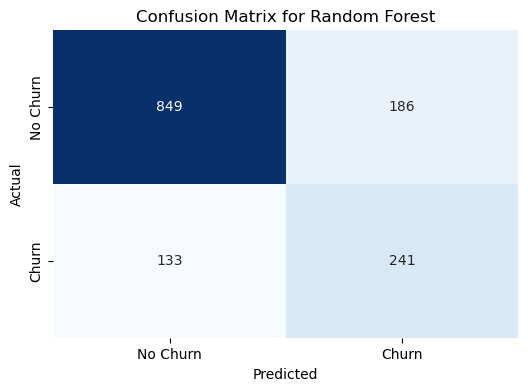

Accuracy Score: 0.7735982966643009
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.56      0.64      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409

Confusion Matrix:
 [[849 186]
 [133 241]]

Evaluating Logistic Regression...


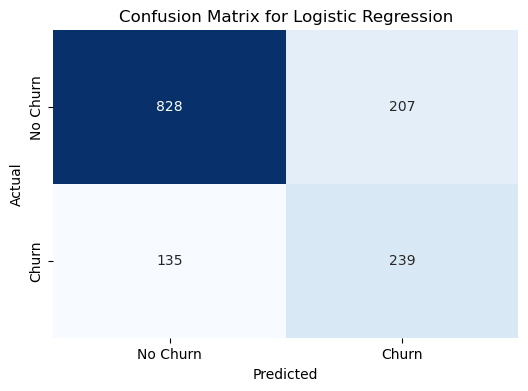

Accuracy Score: 0.7572746628814763
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1035
           1       0.54      0.64      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.76      1409

Confusion Matrix:
 [[828 207]
 [135 239]]

Evaluating XGBoost...


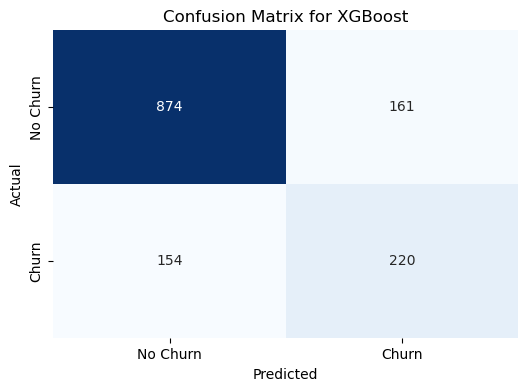

Accuracy Score: 0.7764371894960965
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1035
           1       0.58      0.59      0.58       374

    accuracy                           0.78      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

Confusion Matrix:
 [[874 161]
 [154 220]]

Evaluating LightGBM...


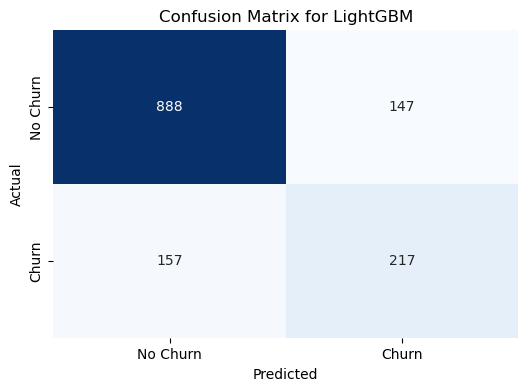

Accuracy Score: 0.7842441447835344
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      1035
           1       0.60      0.58      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

Confusion Matrix:
 [[888 147]
 [157 217]]


In [82]:
for model_name, model in models_calibrated.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", cm)


## 19. Feature Importance Visualization
Finally, we visualize the feature importance for the best performing model, Random Forest, using a bar plot.

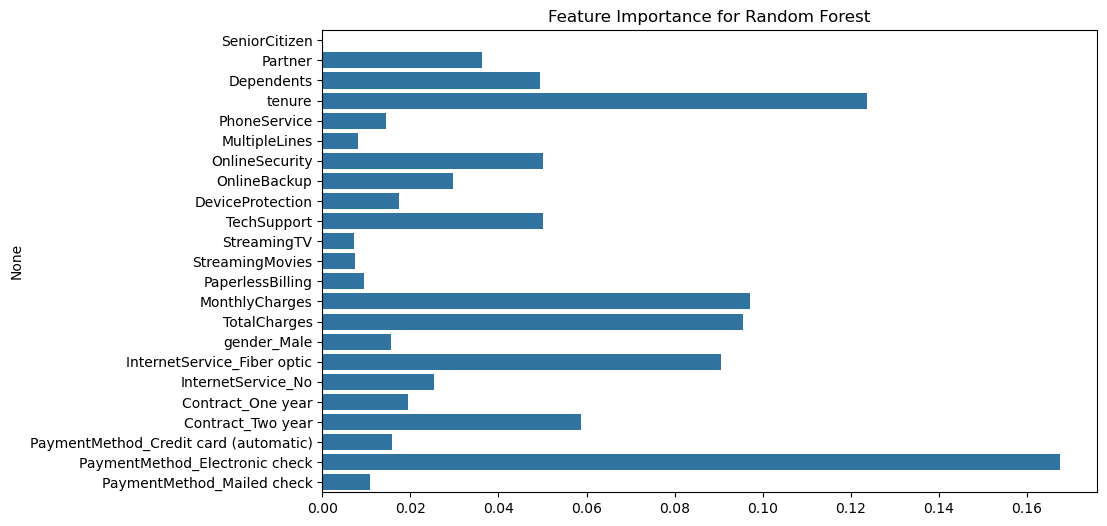

In [63]:
# Feature importance visualization for the best Random Forest model
feature_importances = best_rf.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importance for Random Forest")
plt.show()


## Model Insights:
Random Forest:

Accuracy: 77.36%
Precision (Class 0): 86.46%, Recall (Class 0): 82.03%
Precision (Class 1): 56.44%, Recall (Class 1): 64.44%
F1-score (Class 1): 60.17%

Confusion Matrix:
True Negatives: 849, False Positives: 186
False Negatives: 133, True Positives: 241


Logistic Regression:

Accuracy: 75.73%
Precision (Class 0): 85.98%, Recall (Class 0): 80.00%
Precision (Class 1): 53.59%, Recall (Class 1): 63.90%
F1-score (Class 1): 58.29%

Confusion Matrix:
True Negatives: 828, False Positives: 207
False Negatives: 135, True Positives: 239

XGBoost:

Accuracy: 77.64%
Precision (Class 0): 85.02%, Recall (Class 0): 84.44%
Precision (Class 1): 57.74%, Recall (Class 1): 58.82%
F1-score (Class 1): 58.28%

Confusion Matrix:
True Negatives: 874, False Positives: 161
False Negatives: 154, True Positives: 220

LightGBM:

Accuracy: 78.42%
Precision (Class 0): 84.98%, Recall (Class 0): 85.80%
Precision (Class 1): 59.62%, Recall (Class 1): 58.02%
F1-score (Class 1): 58.81%

Confusion Matrix:
True Negatives: 888, False Positives: 147
False Negatives: 157, True Positives: 217

Conclusion:

Best Performing Model: LightGBM with the highest accuracy (78.42%).
Imbalance in Class 1 (Churned Customers): All models show lower precision and recall for Class 1, suggesting the challenge of predicting the minority class.

Accuracy vs. Recall: While accuracy is good, there is a trade-off with recall for predicting churn, indicating the need for balancing the model's sensitivity to the minority class.